# Scenario 2: SIDARTHE model
This model is already annotated as a biomodels model (model BIOMD0000000955) and can be found here:
https://www.ebi.ac.uk/biomodels/BIOMD0000000955

In [1]:
from IPython.display import Image
from mira.sources.biomodels import get_template_model
from mira.modeling import Model
from mira.modeling.petri import PetriNetModel
from mira.metamodel import model_to_json_file

# Get the model
sidarthe = get_template_model('BIOMD0000000955')

### Simplify model to break up group control

In [2]:
from mira.metamodel.ops import simplify_rate_laws
sidarthe = simplify_rate_laws(sidarthe)
sidarthe.draw_graph('scenario2_sidarthe.png')

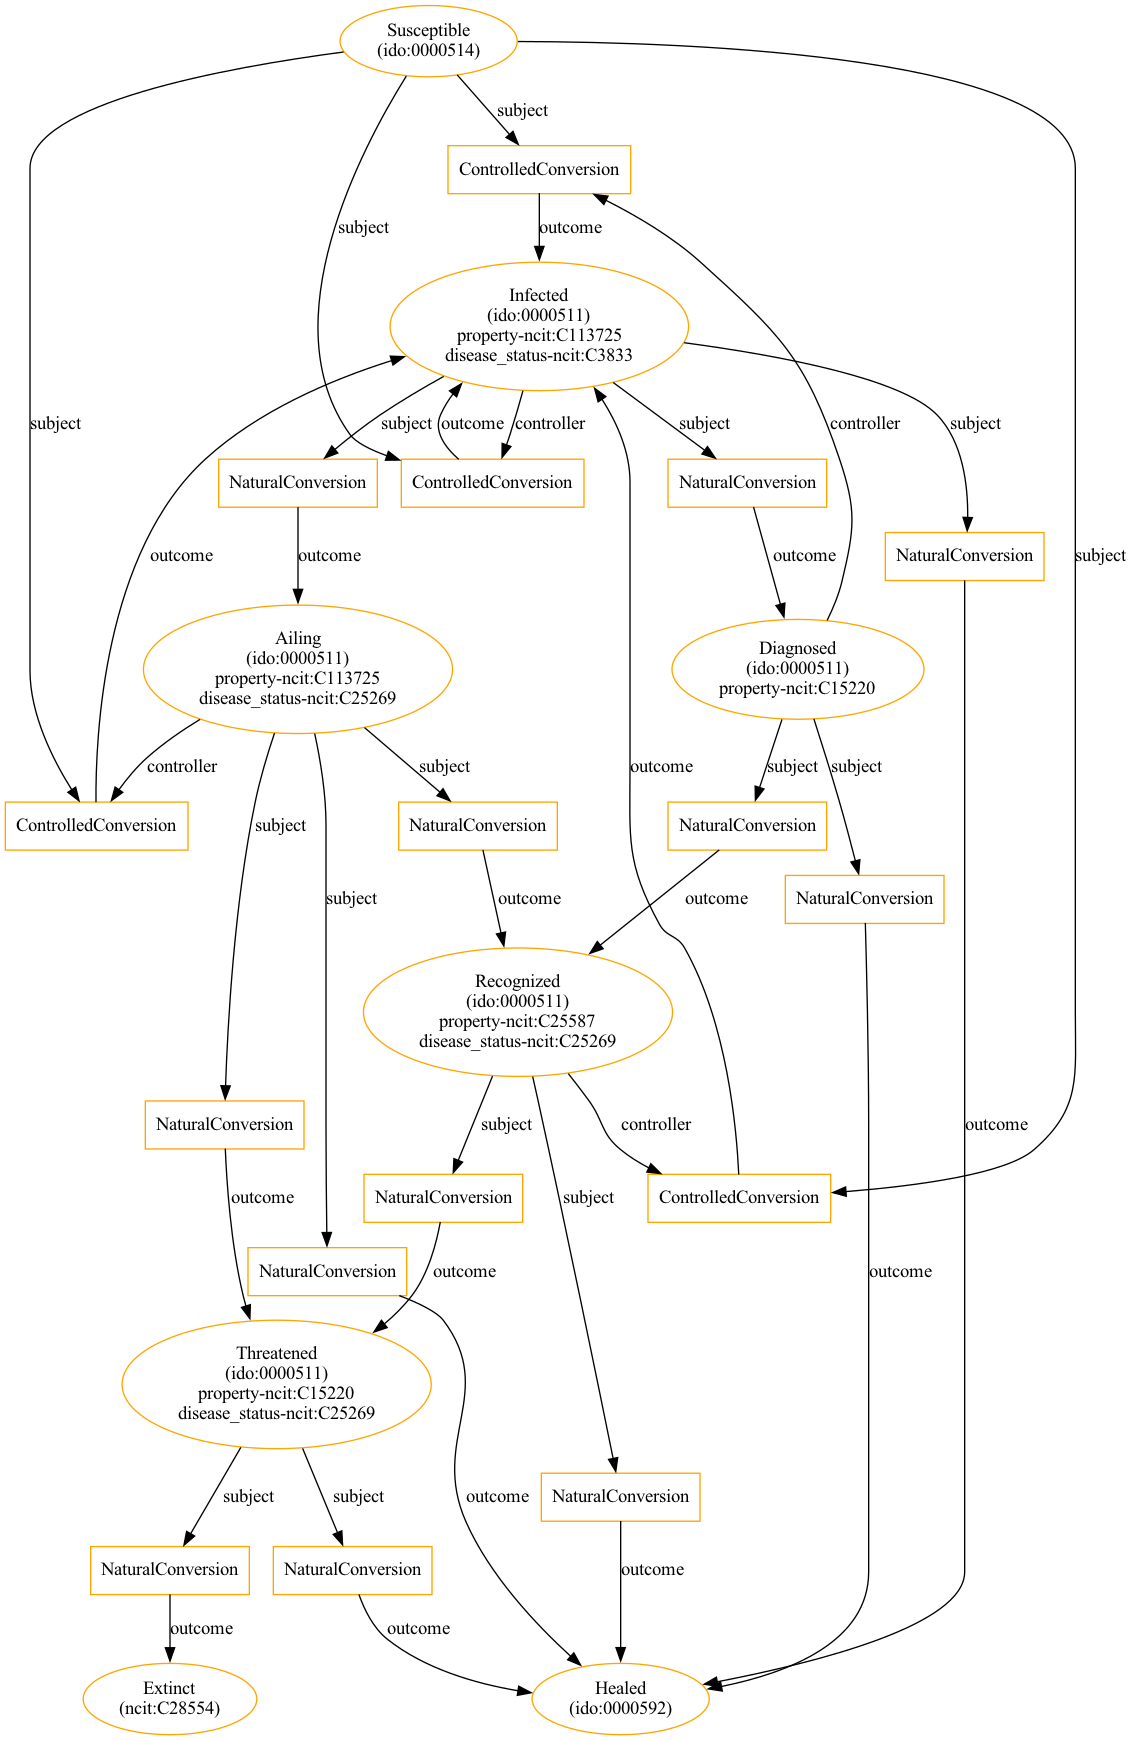

In [3]:
assert sidarthe is not None
Image('scenario2_sidarthe.png')

In [4]:
pm = PetriNetModel(Model(sidarthe))
pm.to_json_file('scenario2_sidarthe.json', indent=1)

In [5]:
model_to_json_file(sidarthe, 'scenario2_sidarthe_mira.json')

In [6]:
sidarthe.templates[1]

ControlledConversion(rate_law=Ailing*Susceptible*gamma, type='ControlledConversion', controller=Concept(name='Ailing', identifiers={'ido': '0000511'}, context={'property': 'ncit:C113725', 'disease_status': 'ncit:C25269'}), subject=Concept(name='Susceptible', identifiers={'ido': '0000514'}, context={}), outcome=Concept(name='Infected', identifiers={'ido': '0000511'}, context={'property': 'ncit:C113725', 'disease_status': 'ncit:C3833'}), provenance=[])

In [7]:
sidarthe.parameters

{'alpha': Parameter(name='alpha', identifiers={}, context={}, value=0.57),
 'beta': Parameter(name='beta', identifiers={}, context={}, value=0.011),
 'gamma': Parameter(name='gamma', identifiers={}, context={}, value=0.456),
 'delta': Parameter(name='delta', identifiers={}, context={}, value=0.011),
 'epsilon': Parameter(name='epsilon', identifiers={}, context={}, value=0.171),
 'theta': Parameter(name='theta', identifiers={}, context={}, value=0.371),
 'zeta': Parameter(name='zeta', identifiers={}, context={}, value=0.125),
 'eta': Parameter(name='eta', identifiers={}, context={}, value=0.125),
 'mu': Parameter(name='mu', identifiers={}, context={}, value=0.017),
 'nu': Parameter(name='nu', identifiers={}, context={}, value=0.027),
 'tau': Parameter(name='tau', identifiers={}, context={}, value=0.01),
 'kappa': Parameter(name='kappa', identifiers={}, context={}, value=0.017),
 'rho': Parameter(name='rho', identifiers={}, context={}, value=0.034),
 'sigma': Parameter(name='sigma', iden

## Add vaccination
According to the scenario description, vaccination is added to the model and is described in this Nature paper: [https://www.nature.com/articles/s41591-021-01334-5](https://www.nature.com/articles/s41591-021-01334-5), see the graphics of the model here: [https://www.nature.com/articles/s41591-021-01334-5/figures/1](https://www.nature.com/articles/s41591-021-01334-5/figures/1)
The vaccination is added as immunizing vaccination, meaning when someone is vaccinated in this model, they are converted to an end-state in the model where they are no longer susceptible to infection.

In [8]:
import sympy
from mira.metamodel import NaturalConversion, GroupedControlledConversion, ControlledConversion, Parameter
from mira.examples.concepts import vaccinated

# Extend the model with vaccination, first pick out the susceptible Concept that already exists in the model
susceptible = None
for template in sidarthe.templates:
    if isinstance(template, ControlledConversion):
        susceptible = template.subject
        if susceptible.get_curie_str() == "ido:0000514":
            break
assert susceptible is not None

vaccination = NaturalConversion(subject=susceptible, outcome=vaccinated)

# Create a new model with vaccination by adding the vaccination process to the existing model
sidarthe_v = sidarthe.add_template(vaccination)

In [9]:
for ix, template in enumerate(sidarthe_v.templates):
    print(ix)
    print(template.type, 'outcome:', template.outcome)
    print(template)

0
ControlledConversion outcome: name='Infected' identifiers={'ido': '0000511'} context={'property': 'ncit:C113725', 'disease_status': 'ncit:C3833'}
rate_law=Diagnosed*Susceptible*beta type='ControlledConversion' controller=Concept(name='Diagnosed', identifiers={'ido': '0000511'}, context={'property': 'ncit:C15220'}) subject=Concept(name='Susceptible', identifiers={'ido': '0000514'}, context={}) outcome=Concept(name='Infected', identifiers={'ido': '0000511'}, context={'property': 'ncit:C113725', 'disease_status': 'ncit:C3833'}) provenance=[]
1
ControlledConversion outcome: name='Infected' identifiers={'ido': '0000511'} context={'property': 'ncit:C113725', 'disease_status': 'ncit:C3833'}
rate_law=Ailing*Susceptible*gamma type='ControlledConversion' controller=Concept(name='Ailing', identifiers={'ido': '0000511'}, context={'property': 'ncit:C113725', 'disease_status': 'ncit:C25269'}) subject=Concept(name='Susceptible', identifiers={'ido': '0000514'}, context={}) outcome=Concept(name='Infe

In [10]:

# Add the vaccination rate law
vaccination.set_mass_action_rate_law("phi")
sidarthe_v.parameters['phi'] = Parameter(name="phi", value=0)

# Modify other rate laws to correspond to the equations in the paper
# Specifically:
# 1. there is now a direct link from R to E with rate tau_2
# 2. the rate for T to E is now tau_1 (changed from just tau)

# Add the new transition from R to E - get the Concepts from existing templates
recognized = sidarthe_v.templates[9].outcome
assert recognized.name == 'Recognized'

T_E_transition = sidarthe_v.templates[14]
extinct = T_E_transition.outcome
assert extinct.name == 'Extinct'

# 1. Create the new transition
recognized_to_death = NaturalConversion(subject=recognized, outcome=extinct)
recognized_to_death.set_mass_action_rate_law("tau_1")
sidarthe_v.parameters['tau_1'] = Parameter(name="tau_1", value=0.00333)

# 2. Modify the rate law for T to E and remove the old parameter name from the parameters dict
T_E_transition.rate_law = T_E_transition.rate_law.subs('tau', 'tau_2')
sidarthe_v.parameters['tau_2'] = Parameter(name="tau_2", value=0.01)
sidarthe_v.parameters.pop('tau')

# Add the new transition
sidarthe_v = sidarthe_v.add_template(recognized_to_death)

In [11]:
# Check the added template
sidarthe_v.templates[-1]

NaturalConversion(rate_law=Recognized*tau_1, type='NaturalConversion', subject=Concept(name='Recognized', identifiers={'ido': '0000511'}, context={'property': 'ncit:C25587', 'disease_status': 'ncit:C25269'}), outcome=Concept(name='Extinct', identifiers={'ncit': 'C28554'}, context={}), provenance=[])

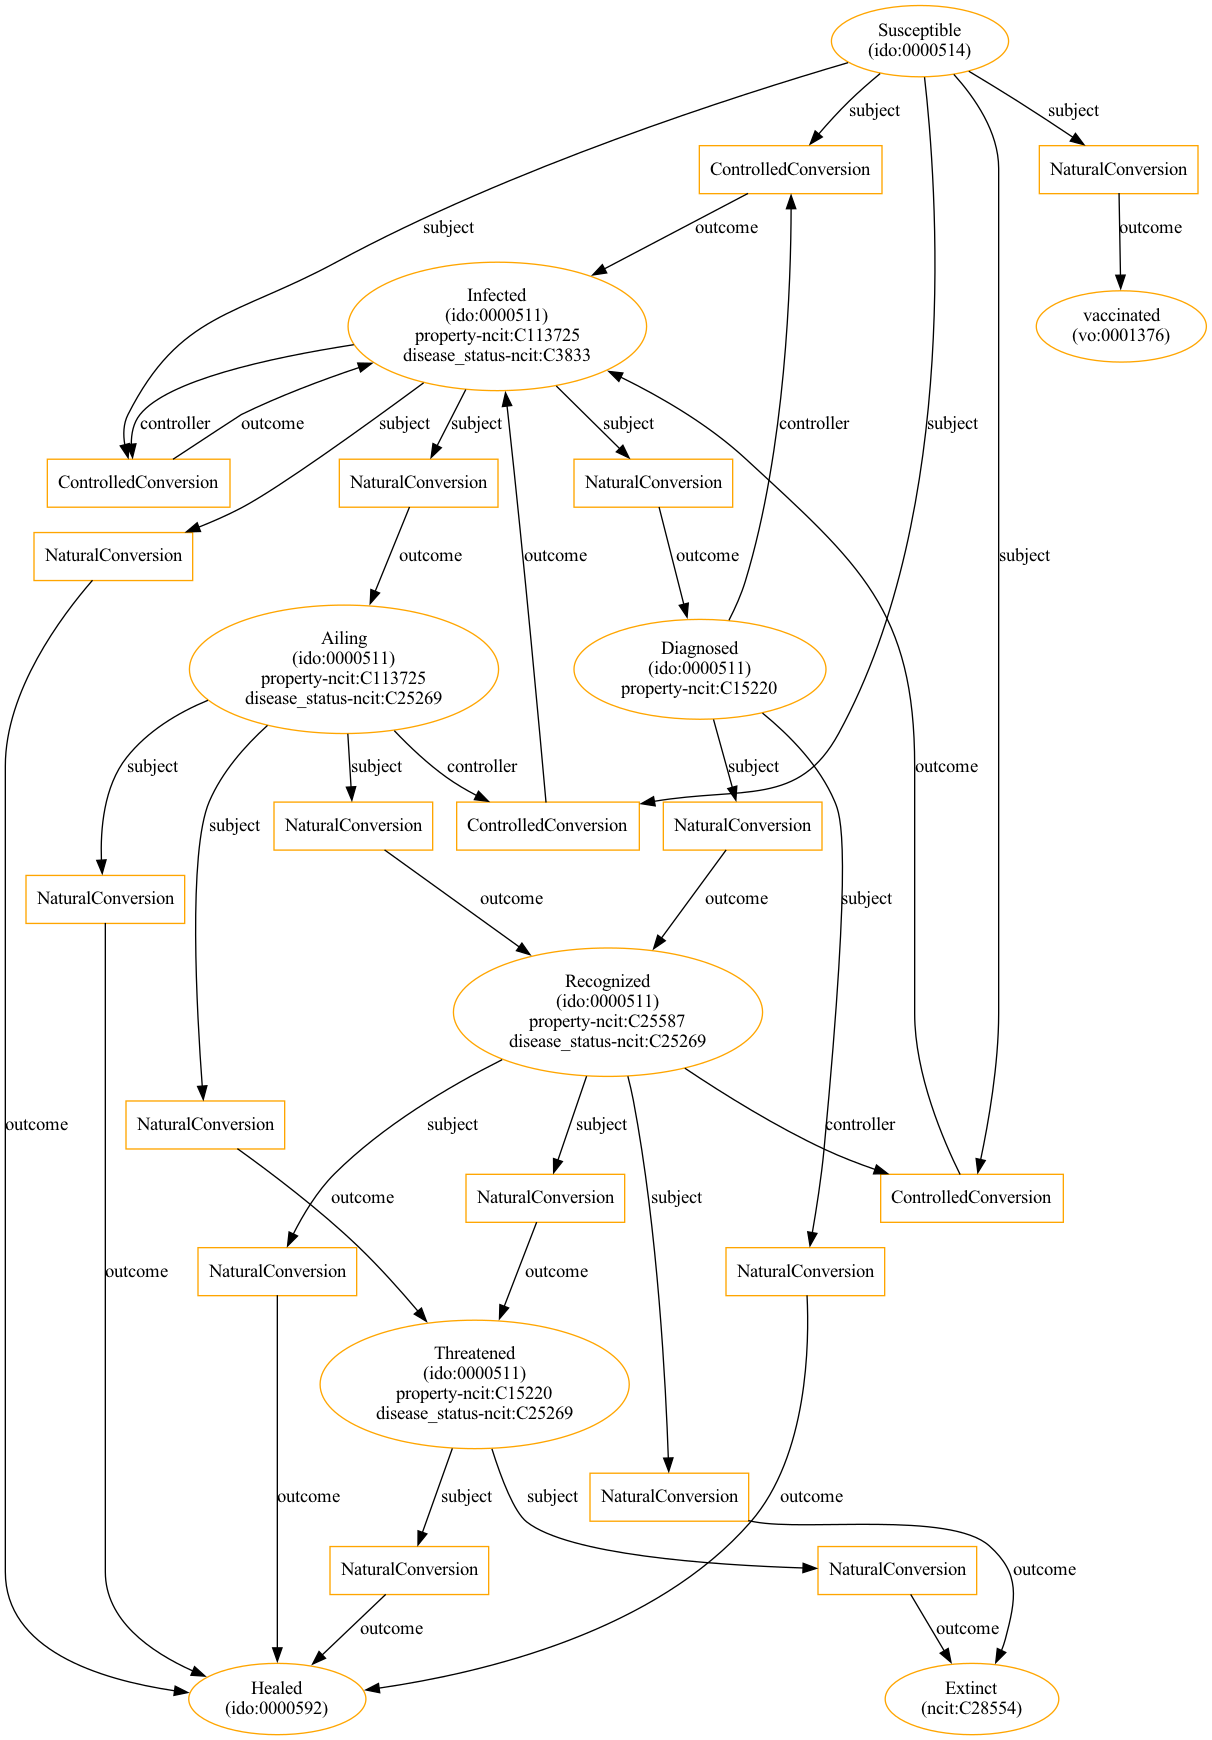

In [12]:
sidarthe_v.draw_graph('scenario2_sidarthe_v.png')
Image('scenario2_sidarthe_v.png')

In [13]:
# Compare the models to see the difference
from mira.dkg.web_client import is_ontological_child_web
from mira.metamodel.templates import TemplateModelDelta

assert len(sidarthe.templates) > 0

tmd = TemplateModelDelta(sidarthe, sidarthe_v, refinement_function=is_ontological_child_web)

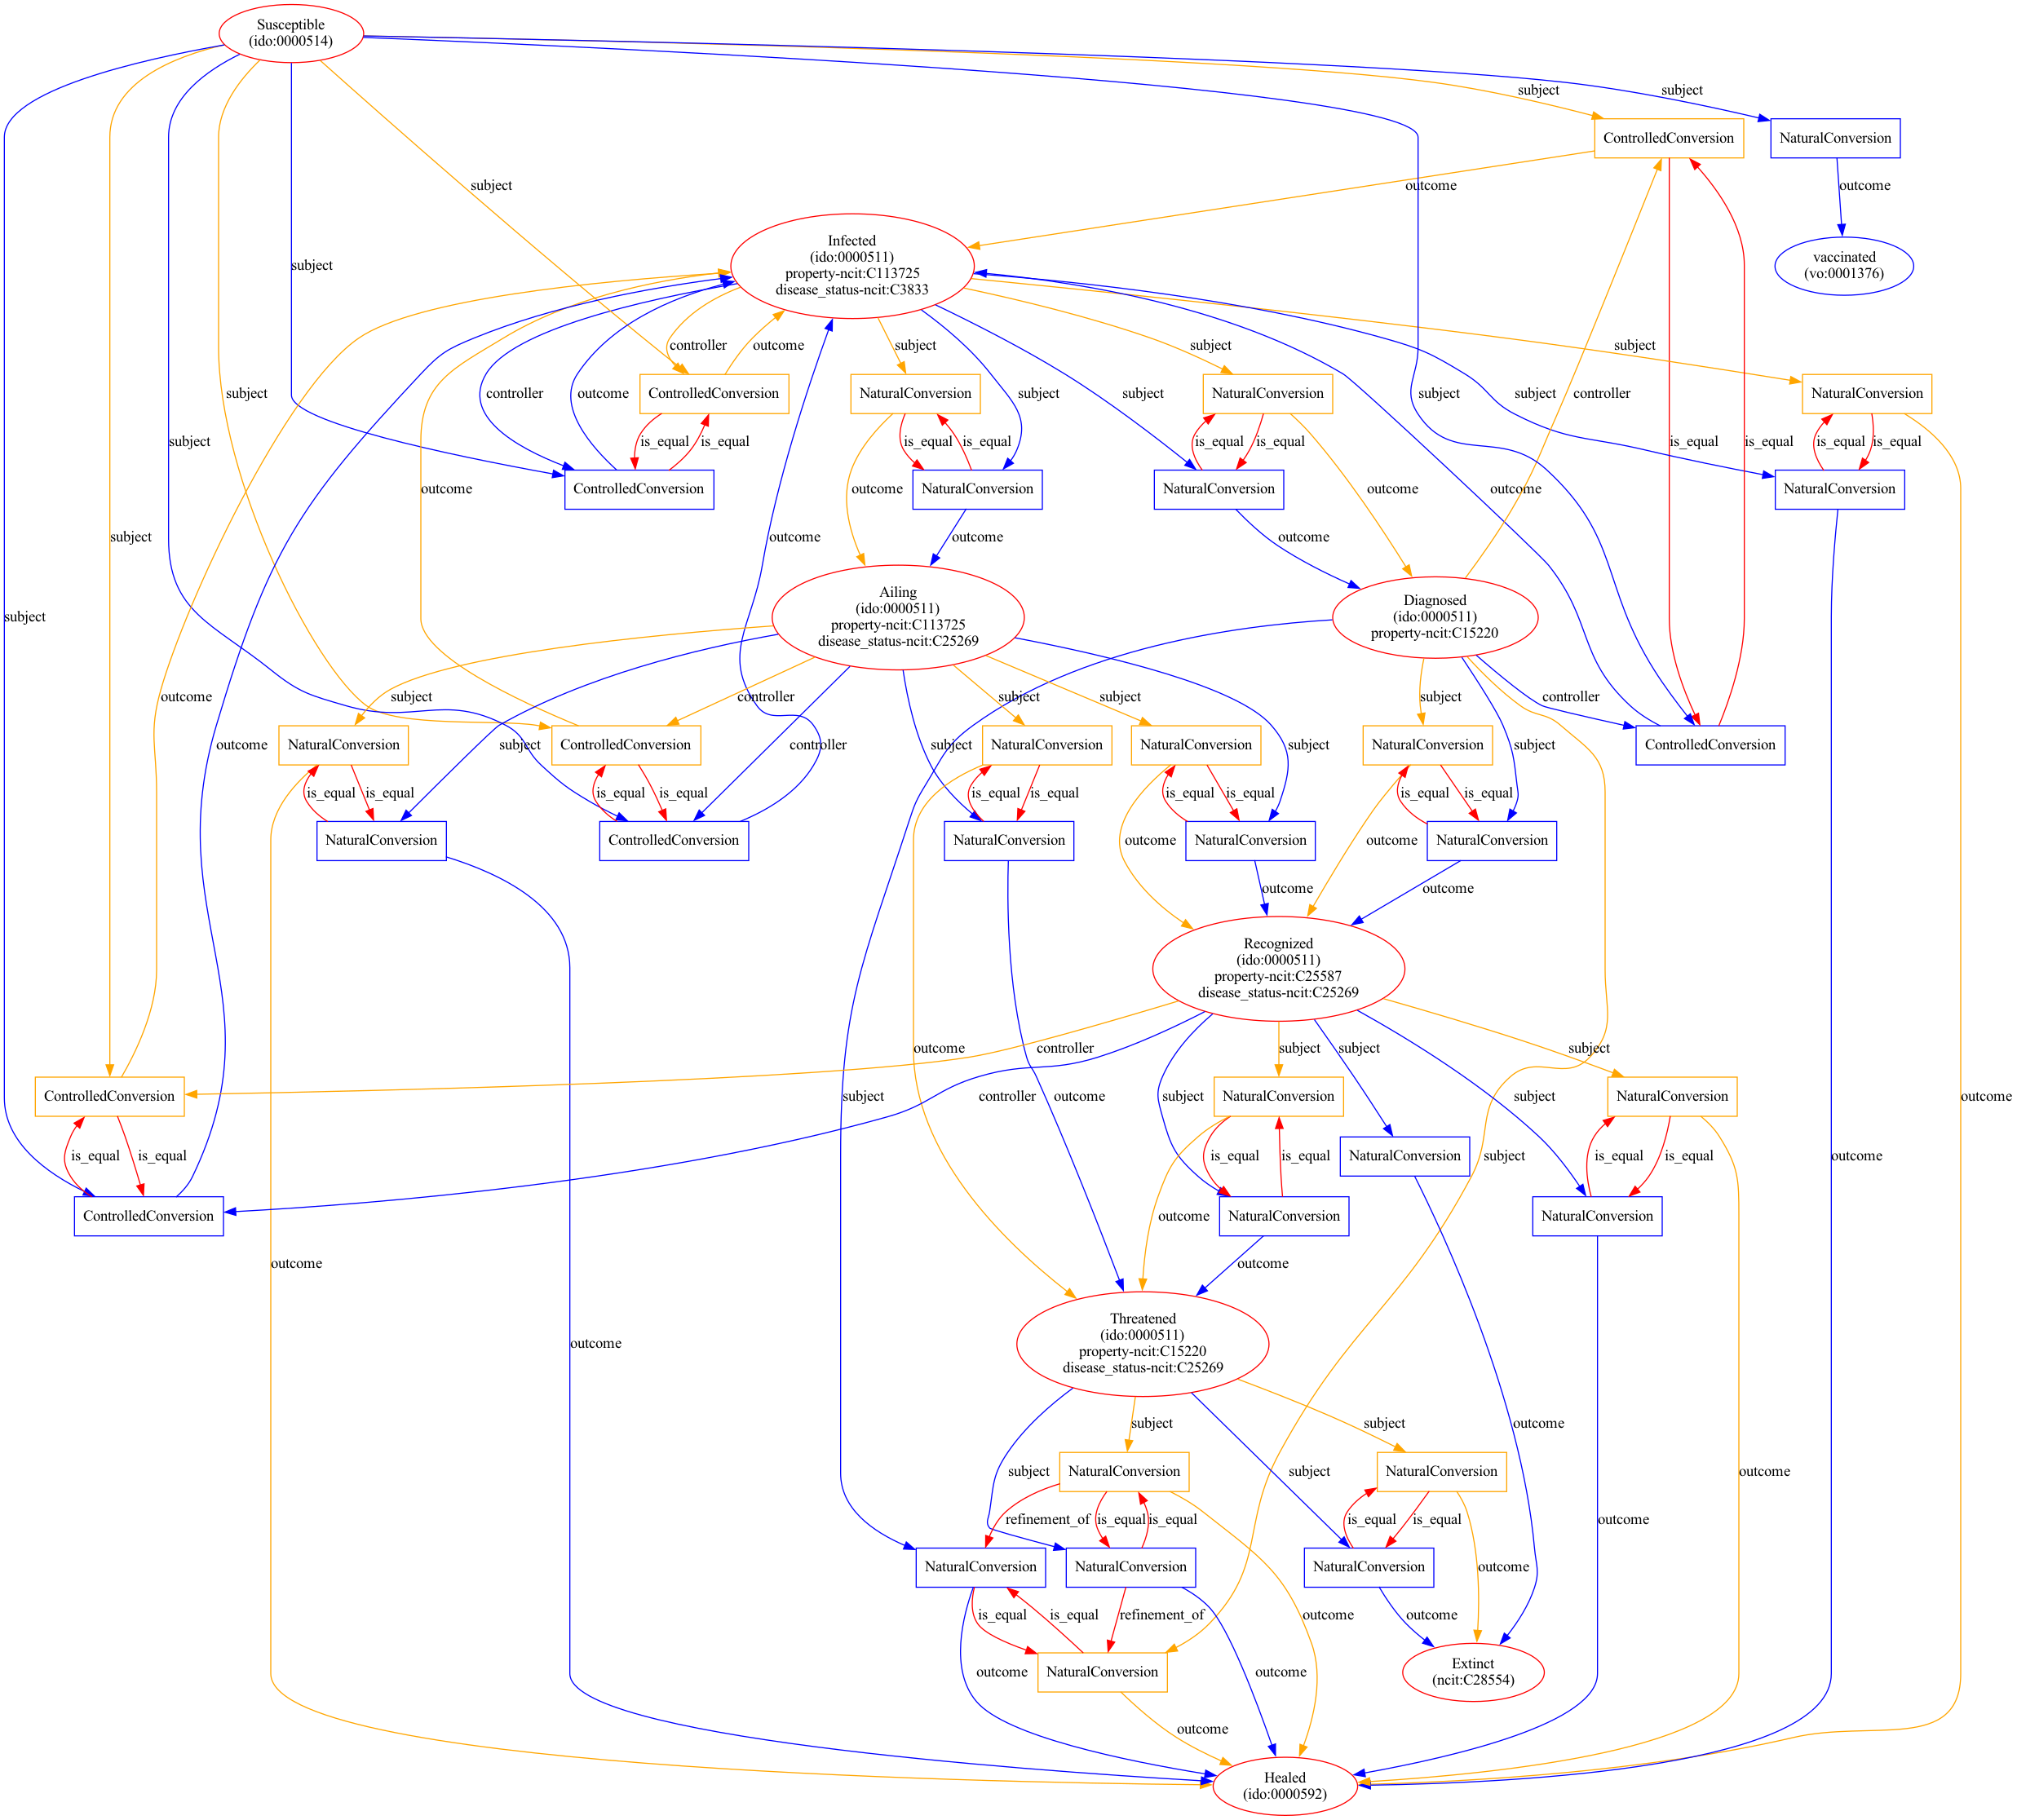

In [14]:
tmd.draw_graph("scenario2_sidarthe_v_diff.png", args="-Grankdir=TB")
Image("scenario2_sidarthe_v_diff.png")

In [15]:
# Export to Petrinet
sidarthe_v_petri = PetriNetModel(Model(sidarthe_v))
sidarthe_v_petri.to_json_file('scenario2_sidarthe_v.json', indent=1)

In [16]:
model_to_json_file(sidarthe_v, 'scenario2_sidarthe_v_mira.json')

In [17]:
sidarthe_v.parameters

{'alpha': Parameter(name='alpha', identifiers={}, context={}, value=0.57),
 'beta': Parameter(name='beta', identifiers={}, context={}, value=0.011),
 'gamma': Parameter(name='gamma', identifiers={}, context={}, value=0.456),
 'delta': Parameter(name='delta', identifiers={}, context={}, value=0.011),
 'epsilon': Parameter(name='epsilon', identifiers={}, context={}, value=0.171),
 'theta': Parameter(name='theta', identifiers={}, context={}, value=0.371),
 'zeta': Parameter(name='zeta', identifiers={}, context={}, value=0.125),
 'eta': Parameter(name='eta', identifiers={}, context={}, value=0.125),
 'mu': Parameter(name='mu', identifiers={}, context={}, value=0.017),
 'nu': Parameter(name='nu', identifiers={}, context={}, value=0.027),
 'kappa': Parameter(name='kappa', identifiers={}, context={}, value=0.017),
 'rho': Parameter(name='rho', identifiers={}, context={}, value=0.034),
 'sigma': Parameter(name='sigma', identifiers={}, context={}, value=0.017),
 'xi': Parameter(name='xi', ident

In [18]:
from mira.metamodel import TemplateModelComparison
tc = TemplateModelComparison([sidarthe, sidarthe_v], refinement_func=is_ontological_child_web)

Comparing model templates: 561it [00:23, 23.63it/s]
Comparing model concepts: 136it [00:17,  7.99it/s]


In [19]:
print(tc.model_comparison.get_similarity_scores())

[{'models': (0, 1), 'score': 0.8888888888888888}]


In [20]:
with open('scenario2_model_comparison.json', 'w') as fh:
    fh.write(tc.model_comparison.json(indent=1))